In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# display the full text of each entry
pd.set_option('display.max_colwidth', -1)

In [3]:
# get wine reviews into a dataframe
df = pd.read_csv('winemag-data_first150k.csv')

Let's look at the dataframe:

In [4]:
df.sample(3)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
49735,49735,US,"Awfully good for the price, with crisp, Carneros acidity and a creamy texture framing nice flavors of pineapples, peaches, green apples, cinnamon spice and minerals.",Lot 127,87,13.0,California,Los Carneros,Napa-Sonoma,Chardonnay,Cameron Hughes
35460,35460,US,"The nose on this Pinot Noir is fresh and bright with scents of fresh raspberries touched with granite minerality. Medium bodied in style, the palate is marked by flavors of cherry cola and currant, wrapping up with a bitter almond finish.",Ingle Vineyard,85,20.0,New York,Finger Lakes,Finger Lakes,Pinot Noir,Heron Hill
26577,26577,US,"Muted on the nose and palate, with dusty notes of mealy apples, this full-bodied, dry blend of Cab Franc and Malbec finishes with just a whisper of dried cherry and strawberry flavors. Drink now.",Topiary,82,14.0,Virginia,Virginia,NaN,Rosé,Boxwood


There are a lot of columns we don't need. The description column contains the review texts, so we need that. We also need a way to measure the sentiment of the reviews. The points column gives a rating out of 100. 

In [5]:
df = df[['description', 'points']]

In [6]:
df.sample(3)

,description,points
73421,"This is mentholated and spicy, with a brandied cherry note as the dominant aroma. Tight but not too severe, it would pair well with meat. Its flavors of raspberry and dry plum are tasty, and the finish hits hard with tightness featuring dry raspberry and cherry skin. A blend of Cabernet Sauvignon, Cab Franc, Merlot and Malbec.",86
56055,"This bottling has been getting seriously good in recent years. Delicious now, a softly rich, decadent wine filled with blackberry tart, cherry pie, blueberry, milk chocolate, anise and pepper flavors, and fully dry. But very high in alcohol, and not an ager.",92
78406,"Soft, rather sweet and appealing. What it lacks in stuffing and complexity, it makes up for in sheer deliciousness. Opulent in raspberries, cherries, red currants, red licorice, Dr. Pepper, bacon, pepper and sandalwood. Drink now–2013.",88


Let's see how many reviews there are:

In [7]:
len(df)

150930

Let's get rid of any duplicate reviews:

In [8]:
df = df.drop_duplicates()

In [9]:
len(df)

97831

It looks like there were a lot of duplicates in the data. Now we know that each review is unique.

Let's look at the range of values in the points column:

In [10]:
df['points'].max()

100

In [11]:
df['points'].min()

80

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000237D3545080>]],
      dtype=object)

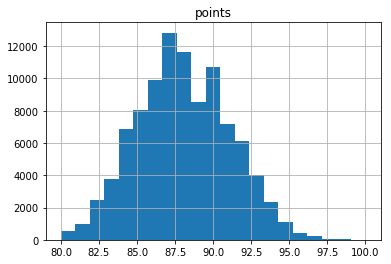

In [12]:
df.hist(column='points', bins=21)

Instead of predicting points as a regression problem, let's create a dataset of reviews that are 'positive' and 'negative'. We can take a certain number of reviews with the lowest ratings and the same number of reviews with the highest ratings to create this dataset.

Let's sort the reviews by points:

In [13]:
df = df.sort_values('points')

We can look at the first five reviews to see the worst ones:

In [14]:
df.head(3)

,description,points
19353,"Barely acceptable. Dry, harsh and vegetal.",80
140172,"Murky and damp smelling, with buttery strawberry flavors. Peppery and dry, with a raw, thin mouthfeel. Acceptable at a base level.",80
140173,"Unpleasantly sharp in acids, and burdened with residual sugar, this is a hard wine to like.",80


And here are the best reviews:

In [15]:
df.tail(3)

,description,points
24151,"A perfect wine from a classic vintage, the 2007 Masseto (100% Merlot from a 17-acre vineyard of the same name) opens with an unabashedly opulent bouquet of delicious blackberry, cherry, chocolate, vanilla, exotic spice and cinnamon. Masseto excels both in terms of quality of fruit and winemaking and delivers plush, velvety tannins and an extra long, supple finish. It will make a special and valuable collection to your cellar.",100
98647,"A spectacular Pinot Noir, but a very young one, and extremely dry. It's a wine of great structure, with rich acids and tannins framing extraordinarily complex flavors of grilled cherries, strawberries and raspberries, with complicating notes of cola, pomegranates, orange zest, anise, dusty Asian spices and smoky sandalwood. A truly great Pinot Noir from a great vintage that needs time in the bottle to express itself. The vineyard, which is owned by the winery, is only 19 acres, planted to an array of newer and older clones. Best after 2013, if you can keep your hands off.",100
92916,"A perfect score has to be considered in the context of its region. Shafer's 2004 Hillside Select is tremendous as a Napa Valley Cabernet Sauvignon that competes with its peers at the highest levels. It's always a fabulous wine, but in warm 2004, Shafer's amphitheater vineyard sheltered the grapes, ripening them to perfection yet protecting the “iron fist in a velvet glove” structure that André Tchelistcheff defined as Stags Leap. This 100% Cabernet is tremendous in cassis, black currant and mocha flavors, and the 100% new French oak provides perfect additions of smoke and caramel. It's soft and gorgeous enough to drink now, and should age well in a cool cellar for the next 20 years.",100


Let's take the 10,000 worst reviews and 10,000 best reviews to create data for the positive and negative categories.

In [16]:
df = pd.concat([df[:10000], df[-10000:]])

In [17]:
df

,description,points
19353,"Barely acceptable. Dry, harsh and vegetal.",80
140172,"Murky and damp smelling, with buttery strawberry flavors. Peppery and dry, with a raw, thin mouthfeel. Acceptable at a base level.",80
140173,"Unpleasantly sharp in acids, and burdened with residual sugar, this is a hard wine to like.",80
140174,"Despite 15-1/2 percent alcohol, this wine still has residual sugar! Think what the brix must have been at harvest. Drinks like a Port, which is a major fault for a dry table wine. Tasted twice, with consistent results.",80
140175,"Heavily toasted, with lemon and burnt-toast aromas. The palate is extremely lemony and short of any lushness normally associated with Merlot. Has color but no ripeness. Proof that Casablanca is not great for Bordeaux varieties.",80
68229,"Flat and soupy, as if the life had been drained out of it. Barely acceptable, even with a big production of 40,000 cases.",80
68230,"Too funky, animal and vegetal to recommend. The wine has color and size but the aromas and flavors just aren't that pleasant. Tastes more like rhubarb and carob than fresh berries.",80
68231,"It's hard to understand why Santa Julia would want to make an oaked Pinot Grigio in Mendoza, but they did. And we find it as odd and difficult to get through as you might expect. The nose is nutty and full of popcorn, while the palate offers heady, honeyed apricot and peach flavors.",80
68232,"Unattractive, with funky, medicinal cherry flavors and a soft, collapsed texture. The oak sticks way out.",80
116550,"Harsh and medicinal, this Zin can be described as rustic. It has dry flavors of cherries and iodine.",80


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000237CC3C9518>]],
      dtype=object)

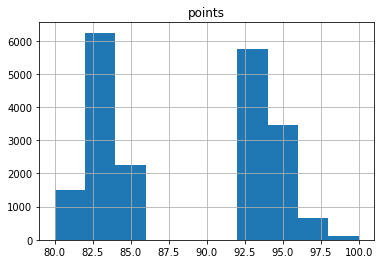

In [18]:
df.hist(column='points')

In [19]:
df['sentiment'] = df['points'].apply(lambda points: 0 if points < 90 else 1)

In [20]:
df = df.drop('points', axis=1)

In [21]:
df

,description,sentiment
19353,"Barely acceptable. Dry, harsh and vegetal.",0
140172,"Murky and damp smelling, with buttery strawberry flavors. Peppery and dry, with a raw, thin mouthfeel. Acceptable at a base level.",0
140173,"Unpleasantly sharp in acids, and burdened with residual sugar, this is a hard wine to like.",0
140174,"Despite 15-1/2 percent alcohol, this wine still has residual sugar! Think what the brix must have been at harvest. Drinks like a Port, which is a major fault for a dry table wine. Tasted twice, with consistent results.",0
140175,"Heavily toasted, with lemon and burnt-toast aromas. The palate is extremely lemony and short of any lushness normally associated with Merlot. Has color but no ripeness. Proof that Casablanca is not great for Bordeaux varieties.",0
68229,"Flat and soupy, as if the life had been drained out of it. Barely acceptable, even with a big production of 40,000 cases.",0
68230,"Too funky, animal and vegetal to recommend. The wine has color and size but the aromas and flavors just aren't that pleasant. Tastes more like rhubarb and carob than fresh berries.",0
68231,"It's hard to understand why Santa Julia would want to make an oaked Pinot Grigio in Mendoza, but they did. And we find it as odd and difficult to get through as you might expect. The nose is nutty and full of popcorn, while the palate offers heady, honeyed apricot and peach flavors.",0
68232,"Unattractive, with funky, medicinal cherry flavors and a soft, collapsed texture. The oak sticks way out.",0
116550,"Harsh and medicinal, this Zin can be described as rustic. It has dry flavors of cherries and iodine.",0


We now have a dataframe with only the reviews and their sentiment scores (0 for negative and 1 for positive).

In [22]:
import re

In [23]:
def tokenize(description):
    return [token for token in re.split('\W+', description.lower()) if token]

In [24]:
df['tokens'] = df['description'].apply(tokenize)

Now let's split the data into training and testing sets.

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
df, test = train_test_split(df, test_size=0.1)
df = df.copy()
test = test.copy()

In [27]:
len(df), len(test)

(18000, 2000)

In [28]:
df

,description,sentiment,tokens
74792,"This is cloudy to the eye, with a mix of vinegar, briny plum and milk chocolate on the nose. The mouthfeel is blowsy, while the flavors are briny and pickled.",0,"[this, is, cloudy, to, the, eye, with, a, mix, of, vinegar, briny, plum, and, milk, chocolate, on, the, nose, the, mouthfeel, is, blowsy, while, the, flavors, are, briny, and, pickled]"
69841,"Martin Mittelbach rolls out this intense, concentrated wine, which packs spice, ripe pineapple and apricots and a final floral character that fills the mouth. A wine to age for at least four years. Screwcap.",1,"[martin, mittelbach, rolls, out, this, intense, concentrated, wine, which, packs, spice, ripe, pineapple, and, apricots, and, a, final, floral, character, that, fills, the, mouth, a, wine, to, age, for, at, least, four, years, screwcap]"
82863,"The new vintage of Viuda Negra (literally, “black widow”) is a third each Cabernet Sauvignon, Cabernet Franc and Merlot. For a red wine it is a real fruitbowl of unusual flavors—peaches, cranberries, cherries soaked in rum. Round and full, quite delicious and yet focused into a finish with persistent, ageworthy tannins, this will be hard to keep in the cellar, but well worth it if you do.",1,"[the, new, vintage, of, viuda, negra, literally, black, widow, is, a, third, each, cabernet, sauvignon, cabernet, franc, and, merlot, for, a, red, wine, it, is, a, real, fruitbowl, of, unusual, flavors, peaches, cranberries, cherries, soaked, in, rum, round, and, full, quite, delicious, and, yet, focused, into, a, finish, with, persistent, ageworthy, tannins, this, will, be, hard, to, keep, in, the, cellar, but, well, worth, it, if, you, do]"
11564,"This is a heartbeat or two from being DOA. Tan in color with an oily heavy mouthfeel, this tastes oxidized and shows almost no pulse.",0,"[this, is, a, heartbeat, or, two, from, being, doa, tan, in, color, with, an, oily, heavy, mouthfeel, this, tastes, oxidized, and, shows, almost, no, pulse]"
64339,"A mixture of Cabernet Sauvignon, Merlot and Petite Sirah, this has a funky smell, and tastes sweet and soft.",0,"[a, mixture, of, cabernet, sauvignon, merlot, and, petite, sirah, this, has, a, funky, smell, and, tastes, sweet, and, soft]"
34221,"This is a rich wine that still retains intense freshness. Botrytised grapes were harvested in early December, giving rich honey and spice flavors. White peach and spiced pears give freshness as well as rich texture to this young wine. Drink as its opulence comes into its own, from 2019.",1,"[this, is, a, rich, wine, that, still, retains, intense, freshness, botrytised, grapes, were, harvested, in, early, december, giving, rich, honey, and, spice, flavors, white, peach, and, spiced, pears, give, freshness, as, well, as, rich, texture, to, this, young, wine, drink, as, its, opulence, comes, into, its, own, from, 2019]"
16562,"A little heavy and rough, but the flavorful cherries, cocoa and spices are tasty, and the wine is clean and balanced.",0,"[a, little, heavy, and, rough, but, the, flavorful, cherries, cocoa, and, spices, are, tasty, and, the, wine, is, clean, and, balanced]"
10202,"Mellow and floral on the nose, this turns loud and aggressive in the mouth. Candied lime and mango flavors finish rugged and screaming.",0,"[mellow, and, floral, on, the, nose, this, turns, loud, and, aggressive, in, the, mouth, candied, lime, and, mango, flavors, finish, rugged, and, screaming]"
30476,"This is the first Col Solare release to bear the Red Mountain appellation. It's a limited-production wine made from Klipsun, Kiona and estate-grown grapes. It feels tight, and it shows great depth of fruit, along with pencil lead, oreo cookie and smoke notes.",1,"[this, is, the, first, col, solare, release, to, bear, the, red, mountain, appellation, it, s, a, limited, production, wine, made, from, klipsun, kiona, and, estate, grown, grapes, it, feels, tight, and, it, shows, great, depth, of, fruit, along, with, pencil, lead, oreo, cookie, and

In [29]:
test

,description,sentiment,tokens
68798,"Starts with thick, raisiny aromas and later perfume and violets enter the scene. But in the mouth it's sort of thick and lumpy, with blackberry and cassis flavors but not much verve, tannin or acidity. Seems top-loaded, without much structure or finish to seal the deal.",0,"[starts, with, thick, raisiny, aromas, and, later, perfume, and, violets, enter, the, scene, but, in, the, mouth, it, s, sort, of, thick, and, lumpy, with, blackberry, and, cassis, flavors, but, not, much, verve, tannin, or, acidity, seems, top, loaded, without, much, structure, or, finish, to, seal, the, deal]"
57449,"Rich, creamy and lush, this is right up to the very high standard set by the rest of Novelty Hill's white wines. It's rare to taste an American Chardonnay with this mix of exotically ripe fruit, baking spices and crisp natural acids. It just hits every base square on, and takes its time rounding third and heading for a home plate finish. A very impressive effort.",1,"[rich, creamy, and, lush, this, is, right, up, to, the, very, high, standard, set, by, the, rest, of, novelty, hill, s, white, wines, it, s, rare, to, taste, an, american, chardonnay, with, this, mix, of, exotically, ripe, fruit, baking, spices, and, crisp, natural, acids, it, just, hits, every, base, square, on, and, takes, its, time, rounding, third, and, heading, for, a, home, plate, finish, a, very, impressive, effort]"
117771,"Cola, cherry and mint aromas give reason for optimisim, but the palate is extraordinarily hard and acidic. Thus the flavors are of lemony citrus more than Tempranillo, and the feel is stark as nails. You can see certain positives but balance and mouthfeel aren't among them.",0,"[cola, cherry, and, mint, aromas, give, reason, for, optimisim, but, the, palate, is, extraordinarily, hard, and, acidic, thus, the, flavors, are, of, lemony, citrus, more, than, tempranillo, and, the, feel, is, stark, as, nails, you, can, see, certain, positives, but, balance, and, mouthfeel, aren, t, among, them]"
21381,"With its concentrated yellow fruits, this is already a powerful wine. It is packed with acidity, toast, peach flavors and minerality, starting out as a gorgeously rich wine from a ripe vintage. Of course, it will age over many years; open in 10 years.",1,"[with, its, concentrated, yellow, fruits, this, is, already, a, powerful, wine, it, is, packed, with, acidity, toast, peach, flavors, and, minerality, starting, out, as, a, gorgeously, rich, wine, from, a, ripe, vintage, of, course, it, will, age, over, many, years, open, in, 10, years]"
43706,"Made using classic Port grape varieties, this is rich and sweet, with chocolate, coffee, orange, plum and spice flavors. Crisp acidity provides needed balance. It shows a complexity that lifts it above the ordinary. Drink now–2015.",1,"[made, using, classic, port, grape, varieties, this, is, rich, and, sweet, with, chocolate, coffee, orange, plum, and, spice, flavors, crisp, acidity, provides, needed, balance, it, shows, a, complexity, that, lifts, it, above, the, ordinary, drink, now, 2015]"
92915,"Two years in a row this has been a subpar wine. Mealy nectarine aromas are barely adequate, while the palate is sour and finishes bitter. Not a foul experience, but unexciting and not really worth a look.",0,"[two, years, in, a, row, this, has, been, a, subpar, wine, mealy, nectarine, aromas, are, barely, adequate, while, the, palate, is, sour, and, finishes, bitter, not, a, foul, experience, but, unexciting, and, not, really, worth, a, look]"
22241,"Soft and ripe, with a sprinkling of pepper and spice, this is a rich, gentle wine. The tannins are open, lying under the lively black and red berry fruits. It will age over the next few years, but is not for the long-term.",1,"[soft, and, ripe, with, a, sprinkling, of, pepper, and, spice, this, is, a, rich, gentle, wine, the, tannins, are, open, lying, under, the, lively, black, and, red, berry, fruits, it, will, age, over, the, next, few, y

Now let's create a dataframe for the lexicon of the reviews corpus.

In [30]:
lexicon = list(set([token for doc in df['tokens'] for token in doc]))

In [31]:
len(lexicon)

16082

In [32]:
df_tokens = pd.DataFrame({'token': lexicon})

In [33]:
df_tokens.sample(10)

,token
6779,lights
10215,caressing
2201,suprising
14018,predominate
11426,unevenly
9158,ripe
8936,3
1624,clark
4718,traditionelle
16047,vino


In [34]:
from collections import Counter

In [35]:
negative_counts = Counter([token for doc in df.loc[df['sentiment'] == 0]['tokens'] for token in doc])

In [36]:
negative_counts.most_common(10)

[('and', 19514),
 ('the', 11577),
 ('a', 9718),
 ('with', 7762),
 ('of', 7085),
 ('flavors', 5221),
 ('is', 4932),
 ('this', 4906),
 ('it', 4605),
 ('wine', 3997)]

In [37]:
df_tokens['negative_count'] = df_tokens['token'].apply(lambda token: negative_counts[token])

In [38]:
df_tokens.sort_values('negative_count', ascending=False).head(10)

,token,negative_count
5180,and,19514
6796,the,11577
12988,a,9718
9230,with,7762
804,of,7085
2565,flavors,5221
6602,is,4932
2285,this,4906
14100,it,4605
1193,wine,3997


In [39]:
positive_counts = Counter([token for doc in df.loc[df['sentiment'] == 1]['tokens'] for token in doc])

In [40]:
positive_counts.most_common(10)

[('and', 27489),
 ('the', 20404),
 ('a', 14075),
 ('of', 13904),
 ('with', 9290),
 ('is', 9226),
 ('this', 8540),
 ('it', 8472),
 ('wine', 7343),
 ('in', 6002)]

In [41]:
df_tokens['positive_count'] = df_tokens['token'].apply(lambda token: positive_counts[token])

In [42]:
df_tokens.sort_values('positive_count', ascending=False).head(10)

,token,negative_count,positive_count
5180,and,19514,27489
6796,the,11577,20404
12988,a,9718,14075
804,of,7085,13904
9230,with,7762,9290
6602,is,4932,9226
2285,this,4906,8540
14100,it,4605,8472
1193,wine,3997,7343
1351,in,3385,6002


In [43]:
ratio = lambda token: (positive_counts[token]+1)/(negative_counts[token]+1)

In [44]:
df_tokens['ratio'] = df_tokens['token'].apply(ratio)

In [45]:
df_tokens['log_ratio'] = df_tokens['ratio'].apply(lambda ratio: math.log(ratio))

In [46]:
df_tokens.sort_values('log_ratio', ascending=False)

,token,negative_count,positive_count,ratio,log_ratio
3701,2020,0,349,350.000000,5.857933
6128,2018,0,282,283.000000,5.645447
8221,94,0,259,260.000000,5.560682
2438,92,0,187,188.000000,5.236442
8520,decade,0,182,183.000000,5.209486
7015,2025,0,163,164.000000,5.099866
10738,barolo,0,149,150.000000,5.010635
5833,93,0,148,149.000000,5.003946
15752,2013,0,137,138.000000,4.927254
9937,2030,0,119,120.000000,4.787492


In [47]:
log_ratio = dict(zip(df_tokens['token'].tolist(), df_tokens['log_ratio'].tolist()))

Let's see how many reviews we can classify correctly:

In [48]:
# don't include tokens with log_ratio below this magnitude
threshold = 2.7

In [49]:
def predict(tokens):
    score = sum(log_ratio[token] for token in tokens if token in log_ratio and abs(log_ratio[token]) > threshold)
    return 1 if score > 0 else 0

In [50]:
df['prediction'] = df['tokens'].apply(predict)

In [51]:
len(df[df['sentiment'] == df['prediction']]) / len(df)

0.9584444444444444

Let's try it with the test set now:

In [52]:
threshold = 2.7
test['prediction'] = test['tokens'].apply(predict)
len(test[test['sentiment'] == test['prediction']]) / len(test)

0.951

Now we can see the prediction next to each entry:

In [53]:
df.sample(3)

,description,sentiment,tokens,prediction
17514,"The Pecchenino began with promising dark berry fruit aromas, mixed with black pepper. Rich and fruit forward, with soft tannins, and good structure. There was, however, a slight volatility to the wine which was more pronounced on the palate. The fruit still dominated, but the wine faded to a short finish.",0,"[the, pecchenino, began, with, promising, dark, berry, fruit, aromas, mixed, with, black, pepper, rich, and, fruit, forward, with, soft, tannins, and, good, structure, there, was, however, a, slight, volatility, to, the, wine, which, was, more, pronounced, on, the, palate, the, fruit, still, dominated, but, the, wine, faded, to, a, short, finish]",0
148185,"This extremely limited (47 cases) Syrah is dedicated to the owners' daughter Jaden, who is pictured on the label. Very classy Wahluke Slope fruit sends up citrus, spice, pineapple and lime aromas over bright, sappy raspberry and cherry fruit.",1,"[this, extremely, limited, 47, cases, syrah, is, dedicated, to, the, owners, daughter, jaden, who, is, pictured, on, the, label, very, classy, wahluke, slope, fruit, sends, up, citrus, spice, pineapple, and, lime, aromas, over, bright, sappy, raspberry, and, cherry, fruit]",1
17843,"Fairly sweet on the nose, with plum and a touch of spice. Things get more rugged in the mouth, where cherry and blackberry flavors carry a medicinal edge. A big Syrah but also a clumsy, heavy-handed one. Proceed with caution.",0,"[fairly, sweet, on, the, nose, with, plum, and, a, touch, of, spice, things, get, more, rugged, in, the, mouth, where, cherry, and, blackberry, flavors, carry, a, medicinal, edge, a, big, syrah, but, also, a, clumsy, heavy, handed, one, proceed, with, caution]",0


Let's try with a random review:

In [54]:
doc = df.sample(1)
doc

,description,sentiment,tokens,prediction
23908,"From Pierre André's Château Corton-André, they can look up at the hill of Corton and the Corton-Charlemagne vineyard. That gives them a neighborly interest. This is reflected in this rich, powerful, muscular wine, full of yellow fruit, ripe wood and tense acidity. It should age for 4–5 years.",1,"[from, pierre, andré, s, château, corton, andré, they, can, look, up, at, the, hill, of, corton, and, the, corton, charlemagne, vineyard, that, gives, them, a, neighborly, interest, this, is, reflected, in, this, rich, powerful, muscular, wine, full, of, yellow, fruit, ripe, wood, and, tense, acidity, it, should, age, for, 4, 5, years]",1


In [55]:
scores = [[token, log_ratio[token]] for token in doc.iloc[0]['tokens']]

In [56]:
scores = pd.DataFrame({'token': doc.iloc[0]['tokens']})

In [57]:
scores['positivity'] = scores['token'].apply(lambda token: log_ratio[token])

In [58]:
scores = scores[abs(scores['positivity']) > 1.8]

In [59]:
scores

,token,positivity
4,château,2.128232
5,corton,3.178054
15,corton,3.178054
18,corton,3.178054
19,charlemagne,2.708050
20,vineyard,2.863186
32,rich,2.570981
33,powerful,3.291713
34,muscular,2.110213
43,tense,1.992430


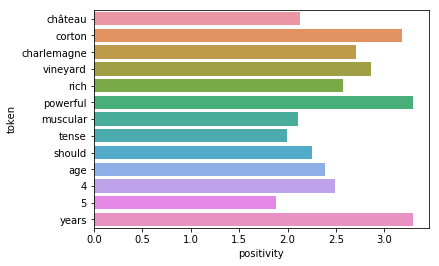

In [60]:
ax = sns.barplot(x="positivity", y="token", data=scores, orient='h')

In [61]:
scores['positivity'].sum()

39.49454057349313